# Предсказание дохода

В этой задаче требуется предсказать уровень дохода человека в зависимости от его места проживания, образования, сферы деятельности и некоторых других факторов. Данные были опубликованы Бюро переписи населения США в 1996 году. Подробное описание датасета вместе с необходимыми файлами находится во вкладке Data.

Используя предложенный набор данных при помощи любого алгоритма необходимо создать модель, которая будет предсказывать уровень дохода человека, то есть какое значение принимает переменная income у лиц id в тестовой выборке.

In [1]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

!pip install catboost
import seaborn as sns
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Импортируем данные из соревнования
train = pd.read_csv('/content/drive/MyDrive/учеба/train.csv')
test = pd.read_csv('/content/drive/MyDrive/учеба/test.csv')

In [4]:
train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K


In [5]:
train['income'].value_counts()

<=50K    22199
>50K      7062
Name: income, dtype: int64

Датасет собран на основе данных Бюро переписи населения США в 1996 году.

### Описание полей датасета:

* возраст: число.
* тип занятости: строка.
* количество человек в данной категории: число.
* образование: строка.
* количество лет обучения: число.
* семейный статус: строка.
* сфера занятости: строка.
* семейная роль: строка.
* пол: строка.
* capital-gain: число.
* capital-loss: число.
* рабочие часы в неделю: число.
* страна рождения: строка.
* заработок: строка, “>50K” или “<=50K”. - целевая переменная

Функции для предобработки данных

In [6]:


def name (df):
  """ Присвоим класс пользователям относительно его замужне-незамужнего положения"""
  Married  = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
  Never  = ['Never-married']
  Divorced  = ['Divorced', 'Separated', 'Widowed']

  df = df.rename({'marital-status': 'marital'}, axis='columns')
  df['brak'] = 0
  df.loc[df.query('marital in @Married').index, 'brak'] = '3'
  df.loc[df.query('marital in @Never').index, 'brak'] = '1'
  df.loc[df.query('marital in @Divorced').index, 'brak'] = '2'
  return df

def contr(df):
  """Для всех стран устанавливаем 0 - для выбраных странн повыщаем коэффицент
  """
  Un  = ['United-States', 'Germany', 'Canada','England','Japan','Italy']
  Me  = ['Mexico', 'Philippines','Puerto-Rico']

  df = df.rename({'native-country': 'country'}, axis='columns')
  df['conrt'] = 0
  df.loc[df.query('country in @Un').index, 'conrt'] = '3'
  df.loc[df.query('country in @Me').index, 'conrt'] = '1'


  df = df.drop(['education','fnlwgt','workclass','marital','relationship','country'], axis=1)
  return df

def dummies(df):
  """Разобьем столбцы occupation','sex методом get_dummies и присоединяем к основной выборки"""
  aaa = pd.get_dummies(df[['occupation','sex']])
  df = df.drop(['occupation','sex'], axis=1)
  df = df.join(aaa)
  return df

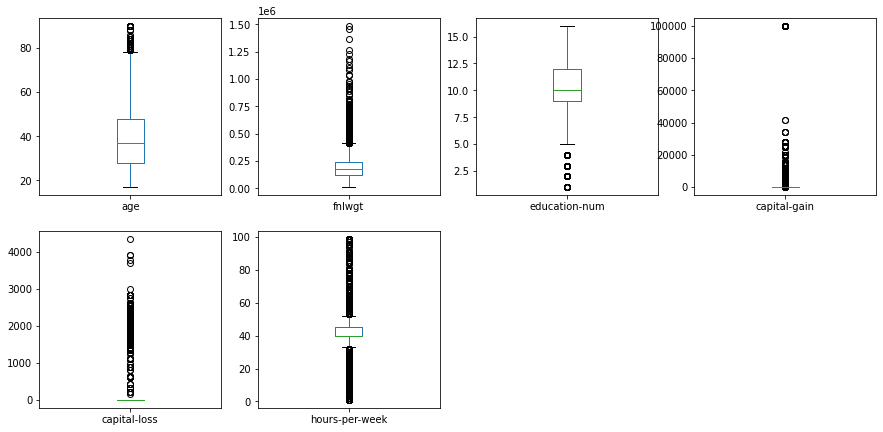

In [7]:
# посмотрим на распределение и выбросы для основной и тестовой выборки

train1=train.drop('income',axis=1).copy()
train1.plot(kind='box', subplots=True, layout=(4,4), sharex=False,sharey=False ,figsize =(15,15))
plt.show()

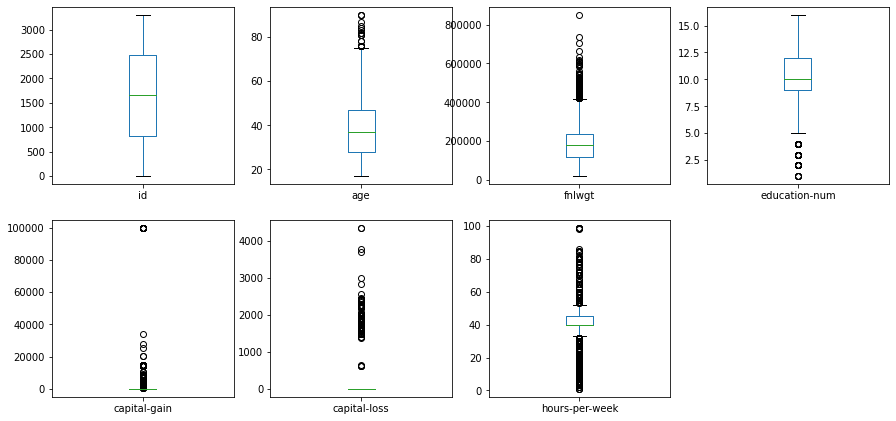

In [8]:
test.plot(kind='box', subplots=True, layout=(4,4), sharex=False,sharey=False ,figsize =(15,15))
plt.show()

Посмотрим на совместную корреляцию числовых признаков

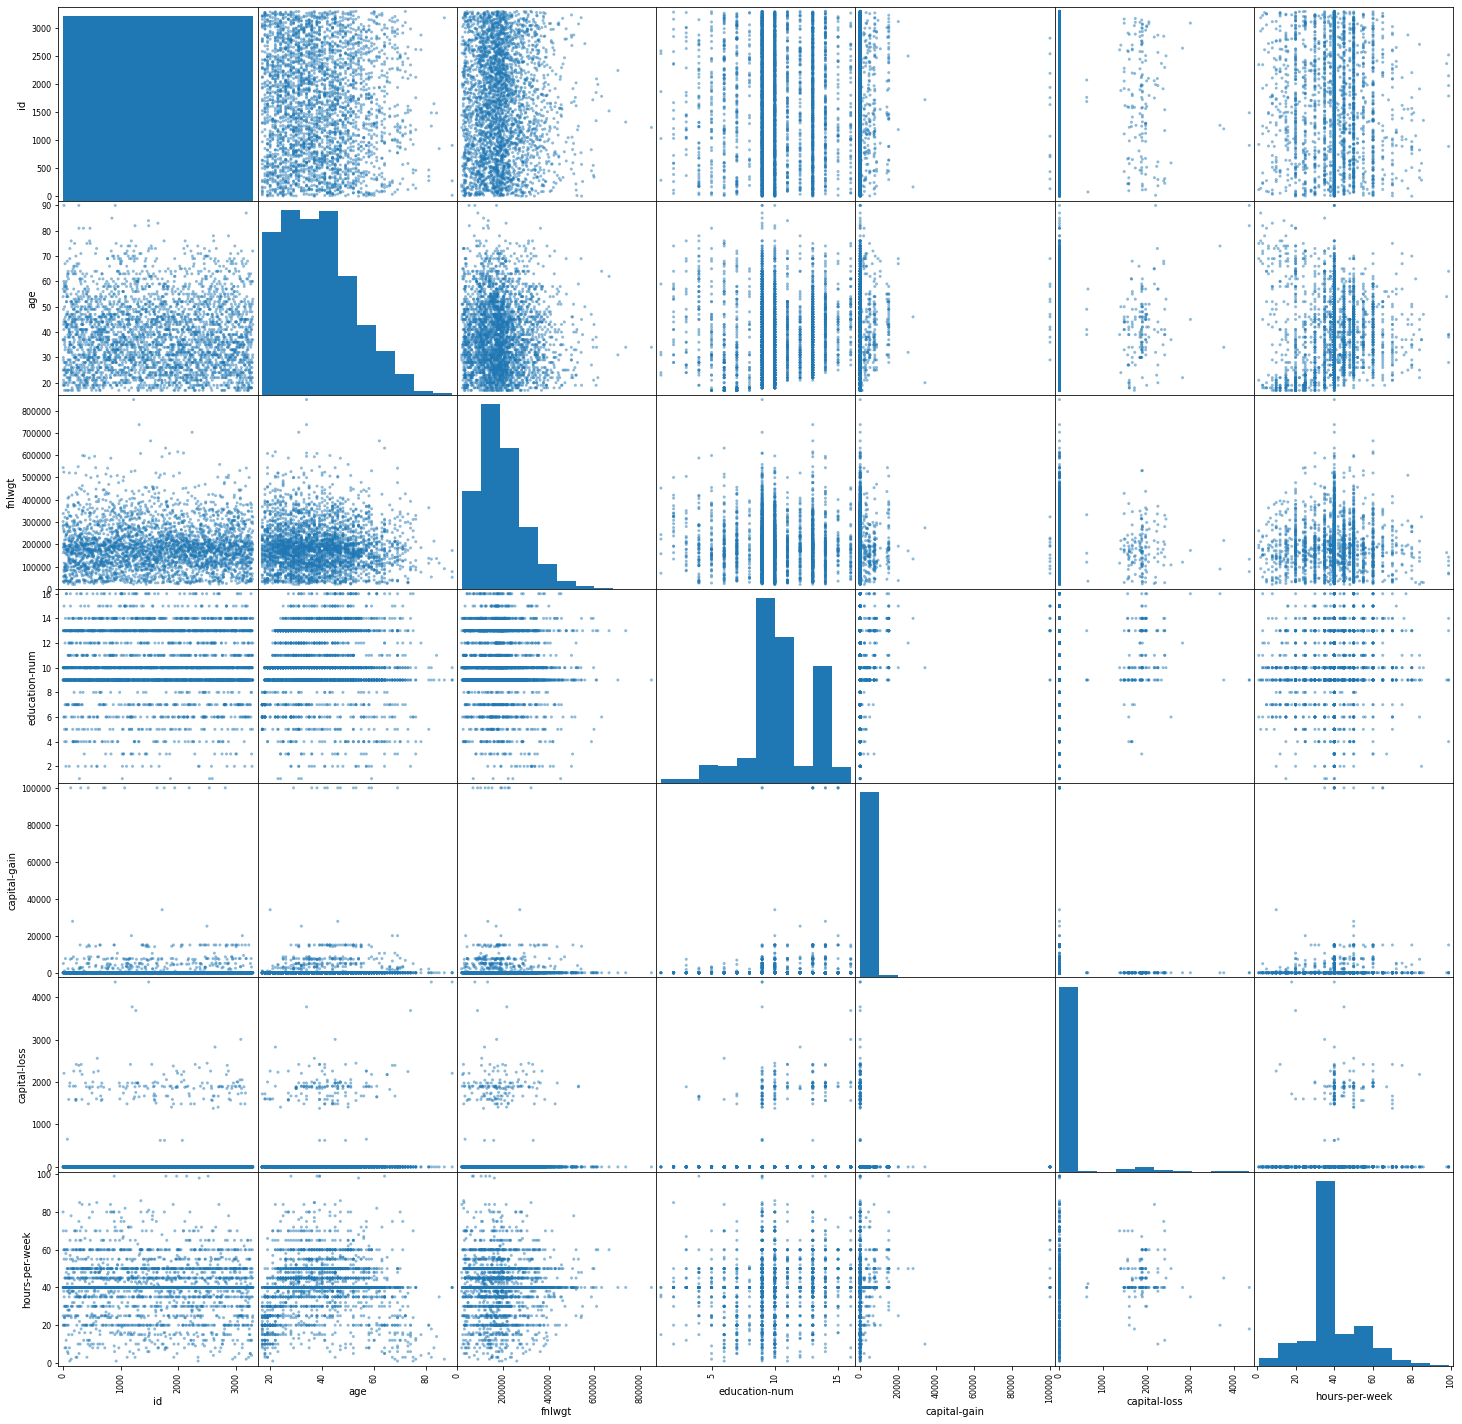

In [9]:
from pandas.plotting import scatter_matrix
p=scatter_matrix(test,figsize=(25, 25))

Видим много 0 значений, выбросов, и данных не несущих пользы. Нам надо убрать выбросы, лишние столбцы,удалить  либо заменить значения - ?, заменить категориальные переменные числовыми. Возможно потребуется устранить дизбаланс классов.

Уберем столбцы с текстом или заменим их на числовые значения

In [10]:
train1 = train.pipe(name).\
               pipe(contr).\
               pipe(dummies)

# чтобы было легче предсказывать заменис данные по доходам на числовые значения
train1['inc'] = 1
train1.loc[train1.query('income == "<=50K"').index, 'inc'] = '0'
train1 = train1.drop(['income'], axis=1)

train1['brak'] = train1['brak'].astype(int)
train1['conrt'] = train1['conrt'].astype(int)
train1['inc'] = train1['inc'].astype(int)
train1 = train1.drop(['occupation_Armed-Forces'], axis=1)
train1.head(5)

,age,education-num,capital-gain,capital-loss,hours-per-week,brak,conrt,occupation_?,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,sex_Female,sex_Male,inc
0,39,13,2174,0,40,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,13,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,38,9,0,0,40,2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,53,7,0,0,40,3,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,28,13,0,0,40,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [11]:
test1 =test.pipe(name).\
               pipe(contr).\
               pipe(dummies)
test1 = test1.drop(['id'], axis=1)

test1['brak'] = test1['brak'].astype(int)
test1['conrt'] = test1['conrt'].astype(int)
test1.head(5)

,age,education-num,capital-gain,capital-loss,hours-per-week,brak,conrt,occupation_?,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,sex_Female,sex_Male
0,37,10,0,0,80,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,54,9,0,0,20,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,19,9,0,0,25,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,57,13,0,0,40,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,25,10,0,0,40,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [12]:
print('Размер обучающей выборки',train1.shape)
print('Размер тестовой выборки',test1.shape)

Размер обучающей выборки (29261, 24)
Размер тестовой выборки (3300, 23)


Обучим модель CatBoostClassifier с различными параметрами. В нашей задаче будем максимизировать метрику accuracy

In [14]:
X = train1.drop(['inc'], axis=1)
y = train1.inc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
cparams = {'depth':range(1,15),
          'iterations':[100],
          'learning_rate':[0.03,0.001,0.1], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,50,100,120,200],
          
          }
model2 = CatBoostClassifier()
c_randomcv_model2=RandomizedSearchCV(estimator=model2,param_distributions=cparams, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)

prediction = c_randomcv_model2.predict(X_test)
print(accuracy_score(y_test, prediction))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


0:	learn: 0.5894853	total: 72.6ms	remaining: 7.19s
1:	learn: 0.5166591	total: 90.1ms	remaining: 4.42s
2:	learn: 0.4657298	total: 107ms	remaining: 3.46s
3:	learn: 0.4266062	total: 124ms	remaining: 2.97s
4:	learn: 0.4003711	total: 141ms	remaining: 2.69s
5:	learn: 0.3809943	total: 158ms	remaining: 2.48s
6:	learn: 0.3659743	total: 176ms	remaining: 2.33s
7:	learn: 0.3545789	total: 192ms	remaining: 2.21s
8:	learn: 0.3452264	total: 212ms	remaining: 2.14s
9:	learn: 0.3381758	total: 231ms	remaining: 2.08s
10:	learn: 0.3323658	total: 250ms	remaining: 2.02s
11:	learn: 0.3280541	total: 268ms	remaining: 1.96s
12:	learn: 0.3242680	total: 289ms	remaining: 1.93s
13:	learn: 0.3212470	total: 307ms	remaining: 1.89s
14:	learn: 0.3183053	total: 323ms	remaining: 1.83s
15:	learn: 0.3161932	total: 341ms	remaining: 1.79s
16:	learn: 0.3138978	total: 359ms	remaining: 1.75s
17:	learn: 0.3118037	total: 376ms	remaining: 1.71s
18:	learn: 0.3098631	total: 394ms	remaining: 1.68s
19:	learn: 0.3084311	total: 411ms	remai

Посмотрим на параметры лучшей модели

In [16]:
prediction = c_randomcv_model2.predict(X_test)
print(accuracy_score(y_test, prediction))
c_randomcv_model2.best_params_

0.8694686485562959


{'border_count': 32,
 'depth': 8,
 'iterations': 100,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

Попробуем на лучших данных

In [24]:
model1 = CatBoostClassifier(border_count =32,  depth = 8, iterations=100, l2_leaf_reg = 5, learning_rate= 0.1)
model1.fit(X_train,y_train) # обучение классификатора
prediction1 = model1.predict(X_test) # передача тестовой выборки в модель

0:	learn: 0.5894853	total: 17.1ms	remaining: 1.69s
1:	learn: 0.5166591	total: 34.4ms	remaining: 1.69s
2:	learn: 0.4657298	total: 52.4ms	remaining: 1.7s
3:	learn: 0.4266062	total: 70.7ms	remaining: 1.7s
4:	learn: 0.4003711	total: 89.8ms	remaining: 1.71s
5:	learn: 0.3809943	total: 108ms	remaining: 1.69s
6:	learn: 0.3659743	total: 126ms	remaining: 1.67s
7:	learn: 0.3545789	total: 143ms	remaining: 1.64s
8:	learn: 0.3452264	total: 161ms	remaining: 1.63s
9:	learn: 0.3381758	total: 179ms	remaining: 1.61s
10:	learn: 0.3323658	total: 196ms	remaining: 1.58s
11:	learn: 0.3280541	total: 213ms	remaining: 1.56s
12:	learn: 0.3242680	total: 236ms	remaining: 1.58s
13:	learn: 0.3212470	total: 256ms	remaining: 1.57s
14:	learn: 0.3183053	total: 273ms	remaining: 1.54s
15:	learn: 0.3161932	total: 290ms	remaining: 1.52s
16:	learn: 0.3138978	total: 306ms	remaining: 1.49s
17:	learn: 0.3118037	total: 326ms	remaining: 1.49s
18:	learn: 0.3098631	total: 349ms	remaining: 1.49s
19:	learn: 0.3084311	total: 367ms	rema

In [25]:
print('Метрика accuracy - ', accuracy_score(y_test, prediction1))
print('Метрика f1 - ', f1_score(y_test, prediction1))

Метрика accuracy -  0.8694686485562959
Метрика f1 -  0.7090632140137091


Обучим на стандартных данных

* border_count =100,  depth = 15, iterations=100, l2_leaf_reg = 3, learning_rate= 0.1

In [17]:
model = CatBoostClassifier(border_count =100,  depth = 15, iterations=100, l2_leaf_reg = 3, learning_rate= 0.1)
model.fit(X_train,y_train) # обучение классификатора
prediction = model.predict(X_test) # передача тестовой выборки в модель

0:	learn: 0.5811340	total: 91.6ms	remaining: 9.07s
1:	learn: 0.5062667	total: 167ms	remaining: 8.18s
2:	learn: 0.4580526	total: 479ms	remaining: 15.5s
3:	learn: 0.4240970	total: 510ms	remaining: 12.2s
4:	learn: 0.3955860	total: 1.48s	remaining: 28s
5:	learn: 0.3721734	total: 2.31s	remaining: 36.2s
6:	learn: 0.3543735	total: 3.15s	remaining: 41.9s
7:	learn: 0.3413961	total: 4.01s	remaining: 46.1s
8:	learn: 0.3317916	total: 4.08s	remaining: 41.3s
9:	learn: 0.3225404	total: 4.92s	remaining: 44.3s
10:	learn: 0.3160386	total: 5.07s	remaining: 41s
11:	learn: 0.3106370	total: 5.9s	remaining: 43.3s
12:	learn: 0.3084299	total: 5.92s	remaining: 39.6s
13:	learn: 0.3035187	total: 6.76s	remaining: 41.5s
14:	learn: 0.2995918	total: 7.59s	remaining: 43s
15:	learn: 0.2959578	total: 8.43s	remaining: 44.2s
16:	learn: 0.2925915	total: 9.26s	remaining: 45.2s
17:	learn: 0.2893427	total: 10.1s	remaining: 46s
18:	learn: 0.2864821	total: 10.9s	remaining: 46.6s
19:	learn: 0.2839020	total: 11.8s	remaining: 47.1

In [18]:
print('Метрика accuracy - ', accuracy_score(y_test, prediction))
print('Метрика f1 - ', f1_score(y_test, prediction))

Метрика accuracy -  0.8660515974713822
Метрика f1 -  0.7043740573152337


Сравним со стандартизированными даными

In [19]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)


model_s = CatBoostClassifier(border_count =100,  depth = 14, iterations=100, l2_leaf_reg = 3, learning_rate= 0.1)
model_s.fit(X_train_st,y_train) # обучение классификатора
prediction_s = model_s.predict(X_test_st) # передача тестовой выборки в модель

0:	learn: 0.5811340	total: 72.4ms	remaining: 7.17s
1:	learn: 0.5062667	total: 145ms	remaining: 7.11s
2:	learn: 0.4580526	total: 390ms	remaining: 12.6s
3:	learn: 0.4240970	total: 419ms	remaining: 10.1s
4:	learn: 0.3960643	total: 865ms	remaining: 16.4s
5:	learn: 0.3724898	total: 1.29s	remaining: 20.2s
6:	learn: 0.3556886	total: 1.71s	remaining: 22.7s
7:	learn: 0.3424728	total: 2.13s	remaining: 24.5s
8:	learn: 0.3317448	total: 2.54s	remaining: 25.7s
9:	learn: 0.3231361	total: 2.96s	remaining: 26.6s
10:	learn: 0.3163162	total: 3.37s	remaining: 27.2s
11:	learn: 0.3105315	total: 3.78s	remaining: 27.7s
12:	learn: 0.3063439	total: 4.18s	remaining: 28s
13:	learn: 0.3020456	total: 4.6s	remaining: 28.3s
14:	learn: 0.2983538	total: 5.02s	remaining: 28.4s
15:	learn: 0.2952218	total: 5.43s	remaining: 28.5s
16:	learn: 0.2929990	total: 5.83s	remaining: 28.5s
17:	learn: 0.2903843	total: 6.24s	remaining: 28.4s
18:	learn: 0.2878573	total: 6.63s	remaining: 28.3s
19:	learn: 0.2859405	total: 7.05s	remaining

In [20]:
print('Метрика accuracy - ', accuracy_score(y_test, prediction_s))
print('Метрика f1 - ', f1_score(y_test, prediction_s))

Метрика accuracy -  0.8655390398086451
Метрика f1 -  0.7013282732447819


Лучшая модель была первой - и без стандартизации

Обучим тестовые данные

In [26]:
submission = model1.predict(test1)

Вернем наши предсказанные данные из 0 и 1 в те, которые нужны по задаче >50K и <=50K

In [27]:
sample_submission = pd.read_csv('/content/drive/MyDrive/учеба/income_sample_submission1.csv')
sample_submission['inc'] = submission
sample_submission['income'] = '>50K'
sample_submission.loc[sample_submission.query('inc == 0').index, 'income'] = '<=50K'
sample_submission = sample_submission.drop(['inc'], axis=1)
sample_submission

,id,income
0,1,>50K
1,2,<=50K
2,3,<=50K
3,4,>50K
4,5,<=50K
...,...,...
3295,3296,<=50K
3296,3297,<=50K
3297,3298,<=50K
3298,3299,<=50K


Сохраняем результат

In [28]:
sample_submission.to_csv('/content/drive/MyDrive/учеба/income_sample_submission1.csv', index=False)